<a href="https://colab.research.google.com/github/wlsisl/ESAA_/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8ch4_%EB%AA%A8%EB%8D%B8%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CH4 모델 훈련

* 모델의 작동 과정을 잘 이해하면 적절한 모델, 올바른 훈련 알고리즘, 작업에 맞는 좋은 하이퍼파라미터를 빠르게 찾을 수 있다.

1) 선형 회귀

훈련 시키는 방법
 - 직접 계싼할 수 있는 공식을 사용하여 훈련 세트에 가장 잘 맞는 모델 파라미터를 해석적으로 구한다. 
 - 경사 하강법이라 불리는 반복적인 최적화 방식을 사용하여 모델 파라미터를 조금씩 바꾸면서 비용 함수를 훈련 세트에 대해 최소화시킨다. 

2) 다항회귀
 * 선형 회귀보다 파라미터가 많아 훈련 데이터에 과대적합되기 쉬움. -> 학습 곡선을 사용해 모델이 과대적합되는지 감지하는 방버브로 살펴봄
 * 과대적합을 감소시킬 수 있는 규제 기법을 알아봄

## 4.1 선형회귀

삶의 만족도 = 세타0 + 세타1 x 1인당_GDP
> 입력 특성인 1인당_GDP에 대한 선형함수이고 세타0과 1은 모델 파라미터


* 머신러닝에서는 종종 벡터를 하나의 열을 가진 2D 배열인 열벡터로 나타냄. 즉 세타와 X가 열벡터라면 예측은 ^y = 세타^Tx이다. 

<선형회귀모델 훈련>
1. 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정 (RMSE를 최소화하는 세타찾기)
  > 회귀에서 가장 널리 사용되는 성능 측정 지표: 평균 제곱근 오차(RMSE) , 실제로는 MSE를 최소화하는 것이 간단함.

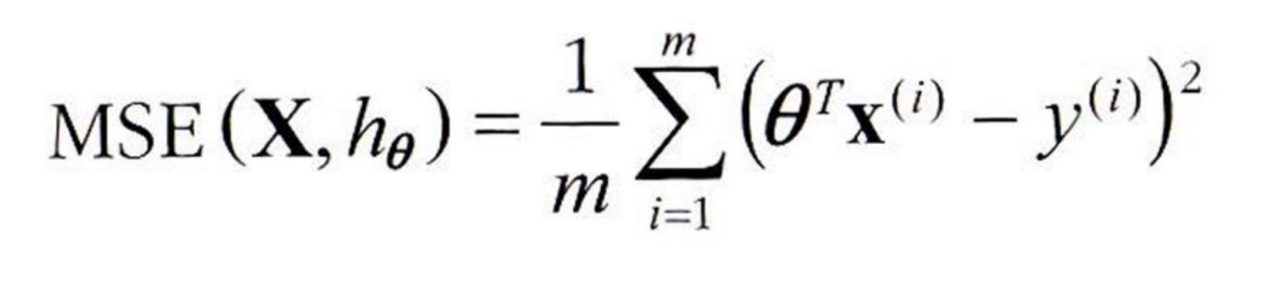

## 4.1.1 정규 방정식

: 비용 함수를 최소화하는 세타값을 찾기 위한 해석적인 방법

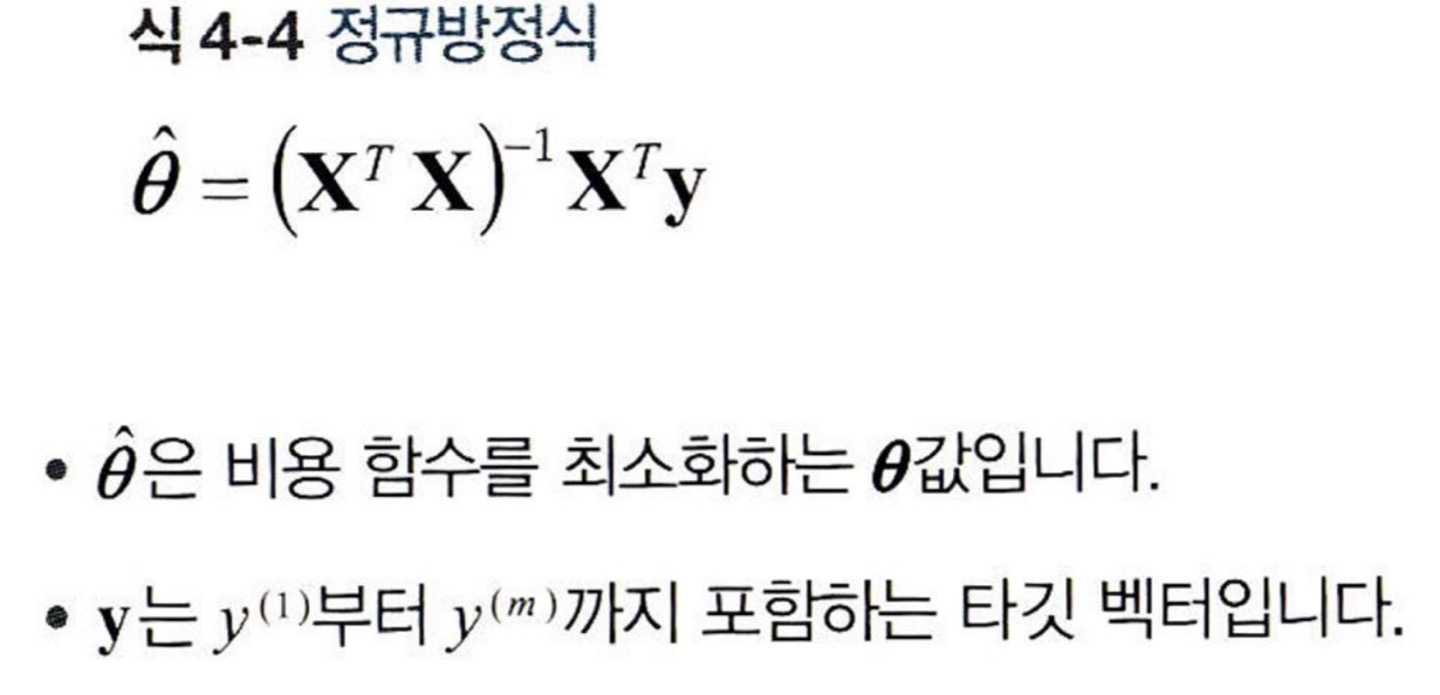

In [27]:
#선형데이터 
import numpy as np

X= 2*np.random.rand(100,1)
y= 4+3*X+np.random.randn(100,1)


In [28]:
#정규 방정식을 사용해 세타헷 계산
X_b = np.c_[np.ones((100,1)),X] #모든 샘플에 x0=1을 추가한다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y) #inv() 함수 : 역행렬 계싼 / dot() : 행렬 곱셈

In [29]:
#정규 방정식으로 계싼한 값 확인
theta_best

array([[3.93740361],
       [3.02675025]])

-> 잡음으로 인해 원래 함수의 파라미터를 정확하게 재현 x

In [30]:
X_new=np.array([[0], [2]])
X_new_b=np.c_[np.ones((2,1)), X_new] #모든 샘플에 x0=1 추가
y_predict=X_new_b.dot(theta_best)
y_predict

array([[3.93740361],
       [9.99090412]])

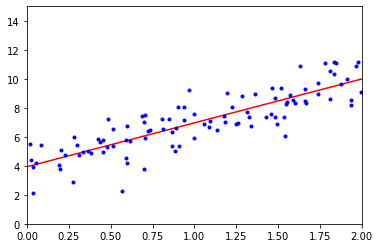

In [31]:
#모델 예측 그래프

import matplotlib.pyplot as plt
plt.plot(X_new, y_predict, "r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

In [32]:
#사이킷런에서 선형회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.93740361]), array([[3.02675025]]))

In [33]:
lin_reg.predict(X_new)

array([[3.93740361],
       [9.99090412]])

In [34]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.93740361],
       [3.02675025]])

In [35]:
# np.linalg.pinv() 함수를 이용해 유사ㅎ역행렬 구하기
np.linalg.pinv(X_b).dot(y)


array([[3.93740361],
       [3.02675025]])

## 4.1.2 계산 복잡도

정규 방정식은 (n+1)(n+1) 크기가 되는 XTX의 역행렬을 계싼한다.
> 사이킷런의 LinearRegression클래스가 사용하는 SVD방법은 (n^2)이다. 즉 특성의 개수가 두 배로 늘어나면 계싼 시간이 대략 4배

* but 훈련 세트의 샘플 수에 대해서는 선형적으로 증가한다.


## 4.2 경사 하강법

: 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘
> 기본 아이디어는 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것

1. 파라미터 벡터 세타에 대해 비용 함수의 현재 그레이디언트를 계싼한다.
2. 그레이디언트가 감소하는 방향으로 진행한다.
3. 그레이디언트가 0이 되면 최솟값에 도달한 것이다.

<학습률> : 경사하강법에서 중요한 파라미터, 스텝의 크기인 학습률은 하이퍼파라미터로 결정된다.
* 학습률이 너무 작을 경우 : 알고리즘이 수렴하기 위해 반복을 많이 진행하므로 시간이 오래 걸림 ->덜 좋은 지역 최솟값에 수렴
* 학습률이 클 경우 : 골짜기를 가로질러 반대편으로 건너뛰게 되어 이전보다 더 높은 곳으로 올라가게 될지도 모름- > 전역 최솟값에 수렴

BUT !! 선형 회귀를 위한 MSE 비용 함수는 **볼록 함수**이기 때문에 어떤 점을 선택해도 곡서을 가로지르지 않음.
-> 연속함수, 기울기가 갑자기 변하지 않고, 지역 최솟값이 없고 전역 최솟값만 존재

### 4.2.1 배치 경사 하강법
경사 하강법 구현 방법 : 각 모델 파라미터 세타J에 대해 비용 함수의 그레이디언트를 계산해야한다. 
> 편도함수 사용 : 세타j가 조금 변경될 때 비용함수가 얼마나 바뀌는지 계산해야한다.

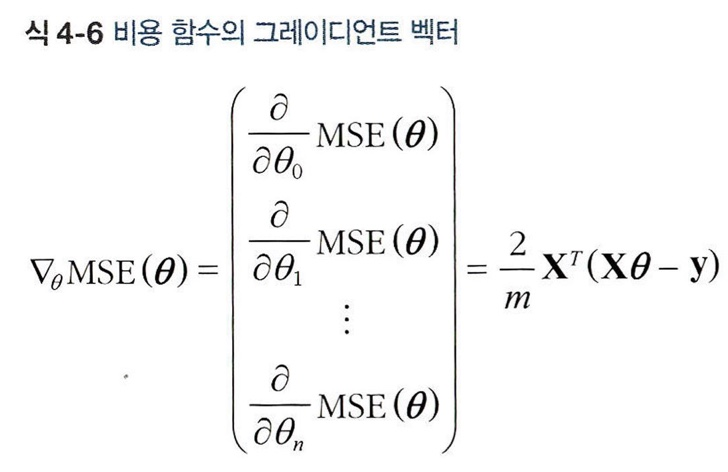


위 공식은 매 경사 하강법 스텝에서 전체 훈련 세트 X에 대해 계산한다. 

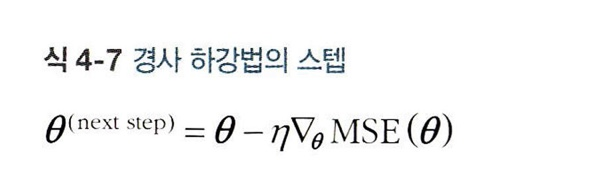

In [36]:
#경사 하강법의 스텝 알고리즘 구현
eta = 0.1 #학습률
n_iterations=1000
m=100

theta = np.random.randn(2,1) #무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
  theta = theta - eta * gradients

In [37]:
theta

array([[3.93740361],
       [3.02675025]])

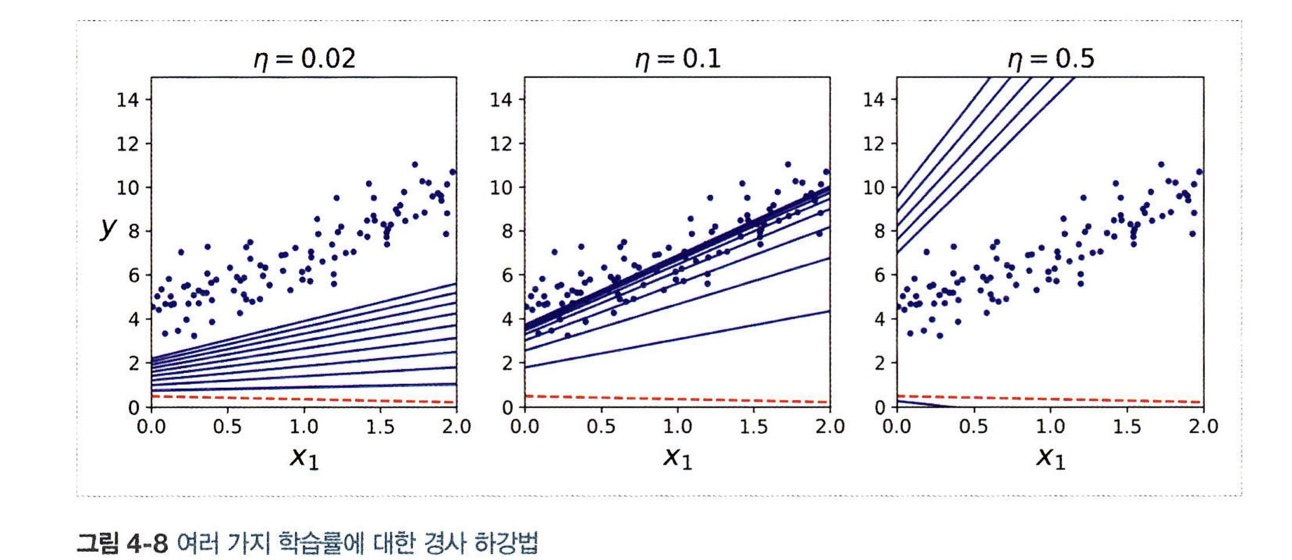

왼쪽은 학습률이 너무 낮다. 알고리즘은 최적점에 도달하겠지만 시간이 오래걸림.

가운데는 학습률이 적당해보인다. 반복 몇번만에 최적점에 수렴했다.

오른쪽은 학습률이 너무 높아서 알고리즘이 이리저리 널뛰면서 스텝마다 최적점에서 발산함.


적절한 학습률을 찾으려면 **그리드 탐색**을 사용

그리드 탐색 반복 횟수 제한 -> 반복횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면(허용오차보다 작아지면), 경사 하강법이 거의 최소에값에 도달한 것이므로 알고리즘을 중지한다.

##4.2.2. 확률적 경사 하강법
> 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트를 계산한다. 

* 확률적이기 때문에 이 알고리즘은 배치 경사 하강법보다 불안정

* 학습률을 점진적으로 감소시키는 것이 좋음

<학습 스케줄>

매 반복에서 학습률을 결정하는 함수

In [38]:
# 학습 스케줄을 사용한 확률적 경사 하강법
n_epochs = 50
t0, t1= 5,50

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index +1]
    yi = y[random_index:random_index+1]
    gradients = 2* xi.T.dot(xi.dot(theta)-yi)
    eta = learning_schedule(epoch * m +i)
    theta = theta - eta * gradients

In [39]:
theta

array([[3.82375819],
       [3.07309901]])

-> 샘플을 무작위로 선택하기 때문에 어떤 샘플은 한 에포크에서 여러번 선택될 수 있고 어떤 샘플은 선택되지 못할 수 있음.

사이킷런에서 SGD방식으로 선형 회귀를 사용하려면 기본값으로 제곱 오차 비용 함수를 최적화하는 SGDRressor 클래스를 사용한다.

In [40]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [41]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.899305]), array([2.9922165]))

## 4.2.3 미니배치 경사 하강법

하나의 샘플을 기반으로 그레이디언트를 계싼하는 것이 아니라 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트를 계산한다. 

장점) 파라미터 공간에서 SGD보다 덜 불규칙

단점) 지역 최솟값에서 빠져나오기는 더 힘들지도 모름

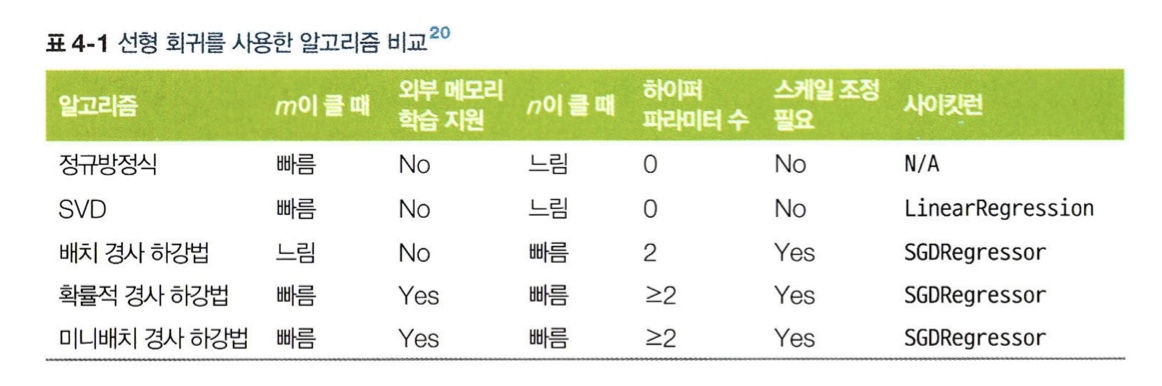

## 4.3 다항회귀

비선형 데이터를 학습하는데 선형 모델을 사용할 수 있다.

In [42]:
#비선형 데이터 생성
m=100
X=6*np.random.rand(m,1)-3
y= 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [44]:
#훈련 데이터 변환
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.48102353])

In [45]:
X_poly[0]

array([2.48102353, 6.15547775])

In [46]:
# 이 확장된 훈련 데이터에 LIG적용
lin_reg= LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.01479389]), array([[1.09514346, 0.49036449]]))

-> PolynomialFeatures로 2차 다항식을 추가함.

##4.4 학습곡선

고차다항회귀를 적용하면 보통 선형 회귀보다 훨씬 더 훈련 데이터에 잘 맞추려고 한다.


<교차 검증 점수로 확인>

훈련 데이터에서 성능이 좋은데 교차 검증 점수가 나쁘면 모델이 과대적합된 것. 

양쪽에 모두 좋지 않으면 과소적합된 것.



<학습 곡선으로 확인>


In [47]:
#훈련데이터에서 모델의 학습 곡선을 그리는 함수
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)
  train_errors, val_errors=[], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict=model.predict(X_train[:m])
    y_val_predict=model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='훈련 세트')
  plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='검증 세트')

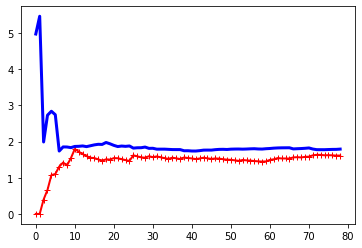

In [48]:
#단순 선형 회귀 모델의 학습 곡선
lin_reg=LinearRegression()
plot_learning_curves(lin_reg, X, y)

-> **과소적합된 모델**

1. 훈련 데이터 성능 살펴보기
* 그래프가 0에서 시작하므로 훈련세트에 하나 혹은 두 개 샘플이 있을 땐 모델이 완벽하게 작동
* 훈련 세트에 샘플이 추가됨에 딸 ㅏ잡음이 있고 비선형이기때문에 모델이 훈련 데이터를 완벽히 학습하는 것이 불가능해짐.

2. 검증 데이터에 대한 모델 성능
* 모델이 적은 수의 훈련 샘플로 훈련될 때는 제대로 일반화 될 수 없어서 검증 오차가 초기에 큼
* 모델에 훈련 샘플이 추가됨에 따라 학습이 되고 검증 오차가 천천히 감소

-> 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 가까이 근접해 있으므로 과소적합 모델의 전형적인 모습임

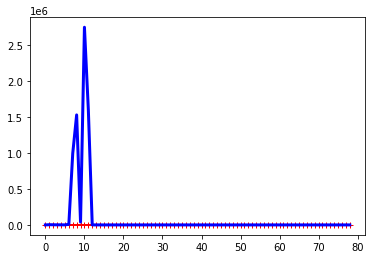

In [49]:
from sklearn.pipeline import Pipeline

polynomial_regression=Pipeline([('poly_features', PolynomialFeatures(degree=10, include_bias=False)), ('lin_reg', LinearRegression())])
plot_learning_curves(polynomial_regression, X, y)

* 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮다.
* 두 곡선 사이에 공간이 있다. 이 말은 훈련 데이터에서의 모델 성능이 검증 데이터에서보다 훨씬 낫다는 뜻이고, 이는 과대적합 모델의 특징이다. 그러나 더 큰 훈련세트를 사용하면 두 곡선이 점점 가까워짐.

> 과대적합 모델 개선 방법 : 검증 오차가 훈련 오차에 근접할 때까지 더 많은 훈련 데이터를 추가하는 것

[편향/분산 트레이드오프]

1. 편향(잘못된 가정으로 인한 것)이 큰 모델은 과소적합되기 쉬움.

2. 분산(변동)이 크면 훈련데이터에 과대적합되는 경우가 되기 쉬움.

-> 모델의 복잡도가 커지면 통상적으로 분산이 늘어나고 편향은 줄어든다.

## 4.5 규제가 있는 선형 모델

> 모델을 규제하여 과대적합을 감소시킨다.

다항 회귀 모델을 규제하는 방법 : 다항식의 차수를 감소시키기 

선형 회귀 모델을 규제하는 방법 : 모델의 가중치 제한

### 4.5.1 릿지 회귀

> 규제가 추가된 선형 회귀 버전

규제항이 비용 함수에 추가된다. 

이는 학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 작게 유지되도록 노력한다. 규제항은 훈련하는 동안에만 비용함수에 추가된다. 모델의 훈련이 긑나면 모델의 성능을 규제가 없는 성능지표로 평가한다.

**하이퍼파라미터 알파**
> 모델을 얼마나 많이 규제할지 조절한다.

알파가 0이면 릿지 회귀는 선형 회귀와 같아진다.

알파가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선이 된다. 



In [50]:
#정규 방정식을 사용한 릿지 회귀 적용
from sklearn.linear_model import Ridge
ridge_reg=Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.19308686]])

In [51]:
#확률적 경사 하강법 사용
sgd_reg=SGDRegressor(penalty='l2') #penalty : 사용할 규제를 지정
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.18141267])

### 4.5.2 라쏘 회귀
> 선형 회귀의 또 다른 규제된 버전, 릿지와 같이 비용 함수에 규제항을 더하지만 l2노름의 제곱을 2로 나눈 것 대신 가중치 벡터의 l1노름을 사용함

<특징>

1. 덜 중요한 특성의 가중치를 제거하려고 한다.
2. 자동으로 희소 모델을 만든다.

<릿지 비용 함수가 라쏘와 다른 점>
1. 파라미터가 전역 최적점에 가까워질수록 그레이디언트가 작아진다.
2. 알파를 증가시킬수록 최적의 파라미터가 원점에 더 가까워진다.

* 라쏘 사용시 경사하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야 한다. 

<라쏘 비용 함수>
1. 세타가=0일 때 서브그레이디언트 벡터를 사용하면 됨

In [52]:
from sklearn.linear_model import Lasso
lasso_reg=Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.15322826])

In [53]:
#확률적 경사 하강법 사용
sgd_reg=SGDRegressor(penalty='l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.18953547])

### 4.5.3 엘라스틱넷
> 릿지 회귀와 라쏘 회귀를 절충한 모델

규제항 : 릿지와 회귀의 규제항을 단순히 더해서 사용, 혼합 정도는 혼합 비율 r을 사용해 조절

* r=0이면 엘라스틱넷은 릿지회귀와 같고 r=1이면 라쏘회귀와 같다. 

In [54]:
#특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관 되어 있을 때는 라쏘가 문제를 일으킴.. 그래서 엘라스틱넷 사용
from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.15194671])

###4.5.4 조기 종료

> 검증 에러가 최솟값에 도달하면 바로 훈련 중지

에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어든다. 그러나 감소하덛ㄴ 검증 에러가 멈추었다가 다시 상승함. -> 과대적합 시작 


In [66]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

#데이터 준비
poly_scaler=Pipeline([('poly_features', PolynomialFeatures(degree=90, include_bias=False)),('std_scaler', StandardScaler())])
X_train_poly_scaled=poly_scaler.fit_transform(X_train)
X_val_poly_scaled=poly_scaler.transform(X_val)

sgd_reg=SGDRegressor(max_iter=1, tol=-np.inf, warm_start=True, penalty=None, learning_rate='constant', eta0=0.0005)
#warm_start=True면 fit()메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다.

minimum_val_error=float('inf')
best_epoch=None
best_model=None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) #훈련을 이어서 진행한다
  y_val_predict=sgd_reg.predict(X_val_poly_scaled)
  val_error=mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epochbest_model = clone(sgd_reg)

InvalidParameterError: ignored

##4.6 로지스틱 회귀
> 추정 확률 50% 넘으면 해당 클래스에 속한다고 예측한다. 양성클래스!
이진 분류기라고 한다.

###4.6.1 확률 추정

로지스틱 회귀는 가중치 합을 계싼한다. 결과값의 로지스틱을 출력해줌.
> 로지스틱 : 0과 1 사이의 값을 출력하는 시그모이드 함수

###4.6.2 훈련과 비용함수

* 훈련의 목적은 양성 샘플에 대해서는 높은 확률을 추정하고 음성 샘플에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 세타를 찾는 것!

* 해당 비용함수는 볼록함수이므로 경사하강법이 전역 최솟값을 찾는 것을 보장한다. 

### 4.6.3 결정 경계

In [57]:
from sklearn import datasets
iris=datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [58]:
X=iris['data'][:, 3:] #꽃잎의 너비
y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 그렇지 않으면 0

<ipython-input-58-d3eecaceb385>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y=(iris['target']==2).astype(np.int) #1 Iris-Virginica면 1, 아니면 0


In [59]:
#로지스틱 훈련
from sklearn.linear_model import LogisticRegression

log_reg=LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

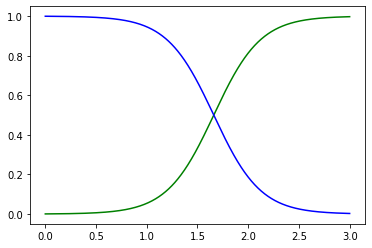

In [60]:
#꽃잎의 너비가 0~3cm 꽃에 대해 모델이 추정 확률을 계산
X_new=np.linspace(0,3,1000).reshape(-1,1)
y_proba=log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica')
plt.plot(X_new, y_proba[:, 0], 'b-', label='Not Iris virginica')

-> 꽃잎 너비는 1.4~2.5에 분포한다. 반면 다른 붓꽃은 일반적으로 꽃잎 너비가 더 작아 0.1~1.8에 분포해 약간 중첩되는 부분이 있다. 

1cm아래 : Iris-Verginica가 아니라고 강하게 확신

2cm 이상 : 맞다고 강하게 확신

즉, 이 두 극단 사이에서는 분류가 확실하지 않음. 일단 클래스를 예측하려고 하면 가장 가능성 높은 클래스를 반환하게될 것. 

결정경계 : 양쪽의 확률이 똑같이 50%가 되는 1.6cm근방

In [61]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

###4.6.4 소프트맥스 회귀

> 직접 다중 클래스를 지원하도록 하는 로지스틱 회귀 모델

개념 : 샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대핟ㄴ 점수를 계싼하고 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정한다.
* 한 번에 하나의 클래스만 예측하므로 하나의 사진에서 여러 사람의 얼굴을 인식하는 데는 사용불가

\
로지스틱 회귀 분류기와 마찬가지로 소프트맥스 회구 분류기는 추정 확률이 가장 높은 클래스를 선택함

[모델 훈련 방법]
* 크로스 엔트로피 비용함수를 최소화 하는 것은 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제해줌, 부합!

In [62]:
X=iris['data'][:, (2,3)] #꽃잎 길이, 꽃잎 너비
y=iris['target']

softmax_reg=LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10) #'multinomial'사용시 소프트맥스 회귀 사용가능
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [63]:
softmax_reg.predict([[5,2]])

array([2])

In [64]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])